In [1]:
import torch
import diffusers
from PIL import Image
from tqdm import tqdm

# setup
model_id = "google/ddpm-celebahq-256"
model = diffusers.UNet2DModel.from_pretrained(model_id)
scheduler = diffusers.DDIMScheduler.from_pretrained(model_id)
scheduler.set_timesteps(50)

/Users/noahbrandt/Documents/Programmierung/Python/Studium/Understanding Deep Learning/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/noahbrandt/Documents/Programmierung/Python/Studium/Understanding Deep Learning/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
An error occurred while trying to fetch google/ddpm-celebahq-256: google/ddpm-celebahq-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [2]:
from IPython.display import display, clear_output, HTML
import base64
import io

def as_image(tensor):
    tensor = (tensor / 2 + 0.5).clamp(0, 1)
    tensor = tensor.permute(0, 2, 3, 1).numpy()[0]
    tensor = (tensor * 255).round().astype("uint8")
    return Image.fromarray(tensor)

def show_image(tensor):
    clear_output(wait=True)
    display(as_image(tensor))

def as_html(tensor):
    image = as_image(tensor)
    buffer = io.BytesIO()
    image.save(buffer, format='PNG')
    image = buffer.getvalue()
    image = base64.b64encode(image).decode()
    return f'<img src="data:image/png;base64,{image}" />'

def show_table(table):
    clear_output(wait=True)
    a = "<table><tr><td><center>"
    b = "</center></td></tr><tr><td><center>"
    c = "</center></td><td><center>"
    d = "</center></td></tr></table>"
    display(HTML(a + b.join(c.join(t) for t in table) + d))


In [3]:
# input prepraration
image_size = model.config.sample_size
input = torch.randn((1, 3, image_size, image_size))

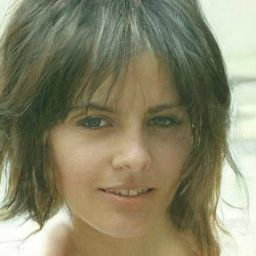

100%|██████████| 50/50 [02:23<00:00,  2.87s/it]


In [4]:
# output generation
current = input
history = list()
for t in tqdm(scheduler.timesteps):
    with torch.no_grad():
        predicted_noise = model(current, t).sample
        current = scheduler.step(predicted_noise, t, current).prev_sample
        history.append(current)
        show_image(current)

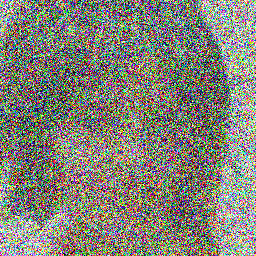

In [29]:
as_image(history[30])

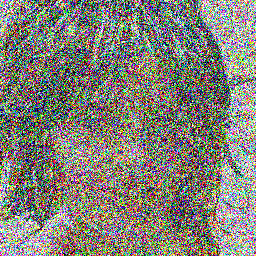

In [74]:
as_image(scheduler.add_noise(current, input, scheduler.timesteps[30]))

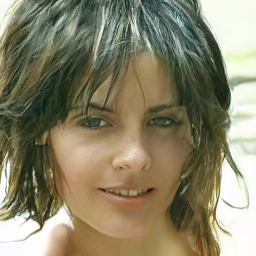

100%|██████████| 21/21 [00:56<00:00,  2.71s/it]


In [51]:
# output generation
current = scheduler.add_noise(history[-1], input, scheduler.timesteps[30])
for t in tqdm(scheduler.timesteps[29:]):
    with torch.no_grad():
        predicted_noise = model(current, t).sample
        current = scheduler.step(predicted_noise, t, current).prev_sample
        show_image(current)

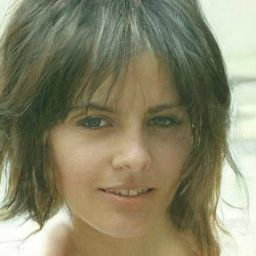

In [52]:
as_image(history[-1])

/var/folders/wg/6xn0c9z91ws0szhmhp8fbqnr0000gn/T/ipykernel_67326/242339735.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image)


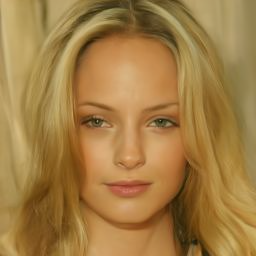

In [68]:
import numpy as np
image = Image.open("../output/ddpm_9.png")
image = torch.from_numpy(np.array(image))
image = image.permute(2, 0, 1).unsqueeze(0)
image = torch.tensor(image)
image = image / 255.0 * 2 - 1
as_image(image)